In [5]:
""" Seq2Seq prediction : Type 4"""
# import libraries

import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [11]:
# data loading 

rain_data = pd.read_csv('rain_day.csv', encoding='utf-8')
dam_data = pd.read_csv('dam_edit.csv', encoding='utf-8')

In [12]:
""" data making part1 : clip data [2000.01.01 - 2023.12.31]"""
# 2000.01.01 = 9496
rain_data = rain_data[['date','211']]
rain_data = rain_data[9496:]
dam_data = dam_data[9496:]

data = pd.merge(rain_data, dam_data, on='date', how='inner')
data = data.fillna(0)

rain_cols = list(data)[1]
dam_cols = list(data)[2]
cols = list(data)[1:]

""" data making part2 : making date, dam & rain data """
# date
dates = pd.to_datetime(data['date'])

# dam
dam = data[['dam_t-1']] # To make DataFrame shape, have to use [[ ]] 

# rain
rain = data[['211']]

# not date data
data_float = data[cols].astype(float)

In [16]:
cols

['211', 'dam_t-1']

In [17]:
""" data making part3 : using scaler each data(dam & rain) """
# rain scaler
scaler_rain = MinMaxScaler(feature_range = (0,1))
rain_scaled = scaler_rain.fit_transform(rain)

# dam scaler
scaler_dam = MinMaxScaler(feature_range = (0,1))
dam_scaled = scaler_dam.fit_transform(dam)

# put two scaled data to one
data_scaled = np.hstack((rain_scaled, dam_scaled))
data_scaled_df = pd.DataFrame(data_scaled, columns=cols, index=data.index)

In [28]:
""" data making part4 : making sequence to fit the model """
def create_sequences(data, features, target, seq_length):
    X, y = [], []
    for i in range(len(data) - (seq_length)):
        x = []
        x.append(data[features].iloc[i:i+seq_length].values)
        x = np.array(x)
        x = np.append(x, data[target].iloc[i+seq_length-1])
        y.append(data[target].iloc[i+seq_length])
        X.append(x)
    return np.array(X), np.array(y)

# deciding sequence length
seq_len = 7
target = 'dam_t-1'
features = rain_cols

# creating X,y data
X, y = create_sequences(data_scaled_df, features, target, seq_len)

In [29]:
""" data making part5 : making Train & Test """
# cutting off the dates by seq_len
adjusted_dates = dates[seq_len:]

# deviding data to "Train & Test"
# Train : 2000.01.01 - 2017.12.31
# Test : 2018.01.01 - 2023.12.31
train_mask = (adjusted_dates >= '2000-01-01') & (adjusted_dates <= '2017-12-31')
test_mask = (adjusted_dates >= '2018-01-01') & (adjusted_dates <= '2023-12-31')

# Train
trainX = X[train_mask]
trainY = y[train_mask]
train_dates = adjusted_dates[train_mask]

# Test
testX = X[test_mask]
testY = y[test_mask]
test_dates = adjusted_dates[test_mask]

# original dam data
train_dam = dam[seq_len:seq_len+len(trainY)]
test_dam = dam[len(trainY)+seq_len:]

In [30]:
""" data making part6 : Editing Train & Test shape """
trainX, trainY = np.array(trainX), np.array(trainY)
testX, testY = np.array(testX), np.array(testY)

trainY = np.expand_dims(trainY, axis=-1) 
testY = np.expand_dims(testY, axis=-1)    

# print shape
print("Train : ", trainX.shape, trainY.shape)
print("Test : ", testX.shape, testY.shape)
print("Original dam : ", train_dam.shape, test_dam.shape)

Train :  (6568, 8) (6568, 1)
Test :  (2191, 8) (2191, 1)
Original dam :  (6568, 1) (2191, 1)


In [31]:
""" Model """

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense

# Encoder
encoder_inputs = Input(shape=(seq_len+1, 1))
encoder_lstm = LSTM(64, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)

# Decoder
decoder_inputs = Input(shape=(seq_len+1, 1))  # Decoder 입력이 seq_len개의 타임스텝
decoder_lstm = LSTM(64, return_sequences=False, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=[state_h, state_c])

# Fully connected layer to generate predictions for each timestep
decoder_dense = Dense(1)  # 각 타임스텝마다 feature 예측
decoder_outputs = decoder_dense(decoder_outputs)

# Seq2Seq 모델
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)    │ (None, 8, 1)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_5 (InputLayer)    │ (None, 8, 1)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_4 (LSTM)                 │ [(None, 64), (None, 64),  │          16,896 │ input_layer_4[0][0]        │
│                               │ (None, 64)]               │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_5 (LSTM)                 │ [(None, 64), (None, 64),  │          16,896 │ input_layer_5[0][0],       │
│                               │ (None, 64)]               │                 │ lstm_4[0][1], lstm_4[0][2] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_2 (Dense)               │ (None, 1)                 │              65 │ lstm_5[0][0]               │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 33,857 (132.25 KB)

 Trainable params: 33,857 (132.25 KB)

 Non-trainable params: 0 (0.00 B)

No weights found, training model from scratch
Epoch 1/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0024 - mae: 0.0165 - val_loss: 7.4522e-04 - val_mae: 0.0084
Epoch 2/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 7.6824e-04 - mae: 0.0107 - val_loss: 7.0857e-04 - val_mae: 0.0124
Epoch 3/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 7.2028e-04 - mae: 0.0096 - val_loss: 6.4930e-04 - val_mae: 0.0083
Epoch 4/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.1538e-04 - mae: 0.0105 - val_loss: 6.4500e-04 - val_mae: 0.0086
Epoch 5/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4.9914e-04 - mae: 0.0094 - val_loss: 6.9354e-04 - val_mae: 0.0140
Epoch 6/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.0042e-04 - mae: 0.0101 - val_loss: 6.3015e-04 - val_mae: 0.0085
Epoch 7/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.2480e-04 - mae: 0.0092 - val_loss: 6.2152e-04 - val_mae: 0.0093
Epoch 8/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.5162e-

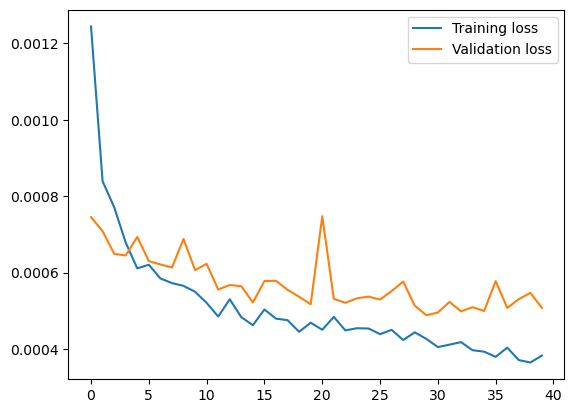

In [32]:
# EarlyStopping callback 
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

#Try to load weights
try:
    model.load_weights('7dam_s2s_type4.weights.h5')
    print("Loaded model weights from disk")
except:
    print("No weights found, training model from scratch")
    # Fit the model
    history = model.fit(
        [trainX, trainX],  # Encoder Input, Decoder Input
        trainY,            # Target Output
        validation_data=([testX, testX], testY),  # test data
        batch_size=32,     # batch size
        epochs=100,        # maximum epoch 
        callbacks=[early_stopping],  # EarlyStopping 
        verbose=1          # processing print
    )
    # Save model weights after training
    model.save_weights('7dam_s2s_type4.weights.h5')
    
    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.legend()
    plt.show()

In [33]:
""" Predict value """
train_pred = model.predict([trainX, trainX])
test_pred = model.predict([testX, testX])

""" applying inverse scaler : to original value """
# train
train_pred_inv = scaler_dam.inverse_transform(train_pred.reshape(-1,1))
trainY_inv = scaler_dam.inverse_transform(trainY.reshape(-1,1))

# test
test_pred_inv = scaler_dam.inverse_transform(test_pred.reshape(-1,1))
testY_inv = scaler_dam.inverse_transform(testY.reshape(-1,1))

""" if value is smaller than 0, change to 0 """
# Train post-processing 
train_pred_clipped = np.maximum(train_pred_inv, 0)
# Test post-processing
test_pred_clipped = np.maximum(test_pred_inv, 0)

206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [34]:
# print shape 
print(trainY.shape, train_pred_clipped.shape, testY_inv.shape, test_pred_clipped.shape)
print("Train data length : ", trainY.shape[0])
print("Test data length : ", testY.shape[0])

# print train / test dates
print("Train : ", train_dates.iloc[0].strftime('%Y-%m-%d'),"~",train_dates.iloc[-1].strftime('%Y-%m-%d'))
print("Test : ", test_dates.iloc[0].strftime('%Y-%m-%d'),"~",test_dates.iloc[-1].strftime('%Y-%m-%d'))

(6568, 1) (6568, 1) (2191, 1) (2191, 1)
Train data length :  6568
Test data length :  2191
Train :  2000-01-08 ~ 2017-12-31
Test :  2018-01-01 ~ 2023-12-31


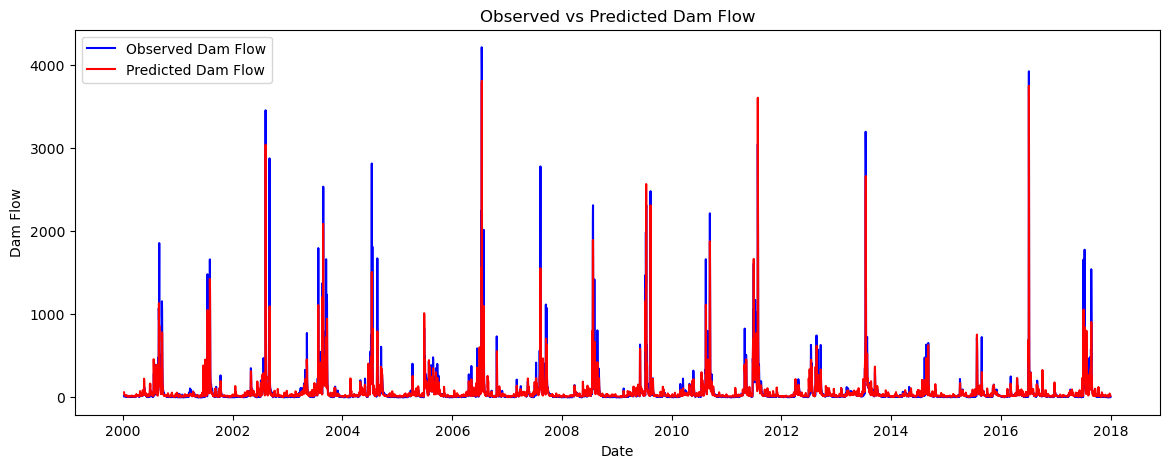

In [35]:
""" Train graph part1"""
# Create the zoomed plot
plt.figure(figsize=(14, 5))

plt.plot(train_dates[:],
         trainY_inv,
         color='blue',
         label='Observed Dam Flow')
plt.plot(train_dates[:],
         train_pred_clipped,
         color='red',
         label='Predicted Dam Flow')

plt.xlabel('Date')
plt.ylabel('Dam Flow')
plt.title('Observed vs Predicted Dam Flow')
plt.legend()
plt.show()

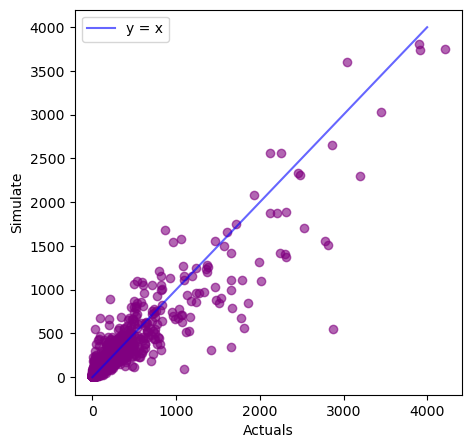

In [36]:
""" Train graph part2 """
# create 1:1 graph (after post-processing, trainY vs trainY_pred)
x = np.arange(0,4000)
y = x

plt.figure(figsize = (5,5))
plt.scatter(trainY_inv[:], train_pred_clipped[:], color = 'purple', alpha = 0.6)
plt.plot(x,y, color = 'blue', alpha = 0.6, label = 'y = x')
plt.xlabel('Actuals')
plt.ylabel('Simulate')

plt.legend()
plt.show()

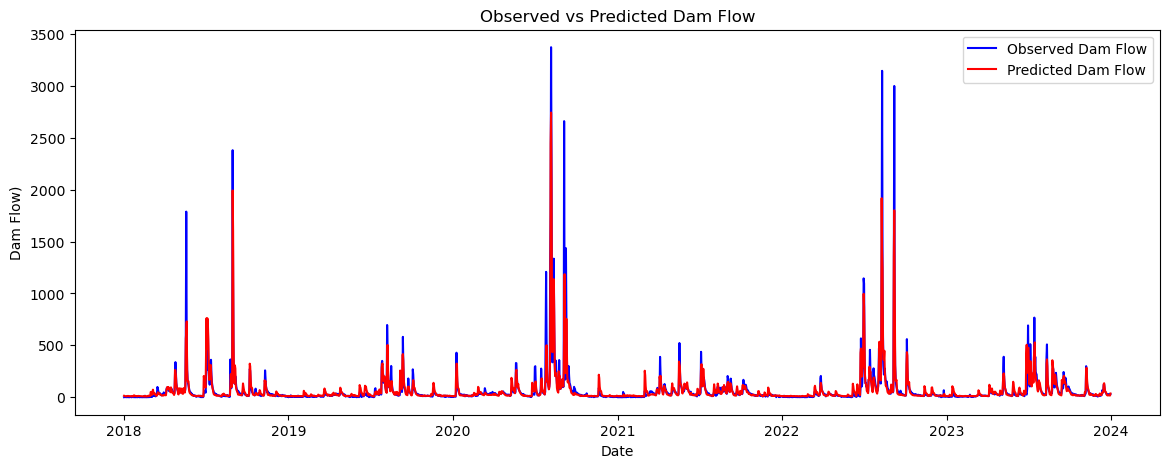

In [37]:
""" Test graph part1"""
# Create the zoomed plot
plt.figure(figsize=(14, 5))

plt.plot(test_dates[:],
         testY_inv,
         color='blue',
         label='Observed Dam Flow')
plt.plot(test_dates[:],
         test_pred_clipped,
         color='red',
         label='Predicted Dam Flow')

plt.xlabel('Date')
plt.ylabel('Dam Flow)')
plt.title('Observed vs Predicted Dam Flow')
plt.legend()
plt.show()

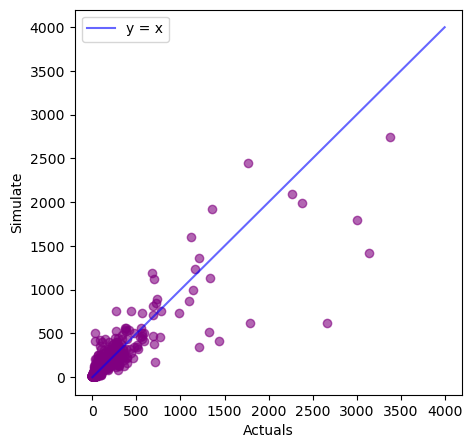

In [38]:
""" Test graph part2 """
# create 1:1 graph (after post-processing, trainY vs trainY_pred)
x = np.arange(0,4000)
y = x

plt.figure(figsize = (5,5))
plt.scatter(testY_inv[:], test_pred_clipped[:], color = 'purple', alpha = 0.6)
plt.plot(x,y, color = 'blue', alpha = 0.6, label = 'y = x')
plt.xlabel('Actuals')
plt.ylabel('Simulate')

plt.legend()
plt.show()

In [39]:
""" Evaluation code """

# Replace these with your actual data
q_obs = testY_inv[:]
q_sim = test_pred_clipped[:]

#RMSE
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(q_obs, q_sim))
print('RMSE : %6.2f' %(rmse))

# NSE
from numpy import mean
num_sum1 = 0
num_sum2 = 0
num_avg = mean(q_obs[:])
for i in range(len(q_obs)):
  num1 = q_obs[i] - q_sim[i]
  num_sum1 += num1**2
  num2 = q_obs[i] - num_avg
  num_sum2 += num2**2

nse = 1 - (num_sum1 / num_sum2)
print('NSE  : %6.2f' % nse.item())  # nse 배열에서 값을 추출해 스칼라로 변환

# PBIAS
num_sum1 = 0
for i in range(len(q_obs)):
  num1 = q_obs[i] - q_sim[i]
  num_sum1 += num1
    
# Calculate means
q_obs_mean = np.mean(q_obs)
q_sim_mean = np.mean(q_sim)

pbias = (num_sum1 / np.sum(q_obs[:])) * 100
print('PBIAS: %6.2f' % pbias.item())  # .item()으로 값을 추출

# Calculate numerator and denominators
numerator = np.sum((q_obs - q_obs_mean) * (q_sim - q_sim_mean))
denominator = np.sqrt(np.sum((q_obs - q_obs_mean)**2) * np.sum((q_sim - q_sim_mean)**2))

# Calculate R^2
R_squared = (numerator / denominator)**2

print("R^2  : %6.2f"%R_squared)

RMSE :  93.02
NSE  :   0.77
PBIAS:  -2.54
R^2  :   0.78
